# Bird Species Classification – Dataset Exploration

## Objective

In this notebook, we explore the **CUB-200-2011 dataset**, which contains **11,788 images of 200 bird species**.  

The main goals of this notebook are:
- Import and describe the dataset  
- Understand the dataset structure using metadata files  
- Perform exploratory data analysis (EDA) with graphs and summary statistics  
- Display sample images with their species names  

This analysis will prepare us for later steps:
1. Preprocessing images (resize, normalize, augment)  
2. Model training and evaluation  
3. Building a web app for bird species recognition 

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm

## Load Dataset Metadata

In [2]:
BASE_DIR = "Image_Raw"

In [3]:
images = pd.read_csv(f"{BASE_DIR}/images.txt", sep=" ", names=["image_id", "file_path"])
labels = pd.read_csv(f"{BASE_DIR}/image_class_labels.txt", sep=" ", names=["image_id", "class_id"])
classes = pd.read_csv(f"{BASE_DIR}/classes.txt", sep=" ", names=["class_id", "class_name"])
split = pd.read_csv(f"{BASE_DIR}/train_test_split.txt", sep=" ", names=["image_id", "is_train"])

In [4]:
df = (
    images
    .merge(labels, on="image_id")
    .merge(classes, on="class_id")
    .merge(split, on="image_id")
)

In [5]:
df["full_path"] = BASE_DIR + "/images/" + df["file_path"]
df["set"] = df["is_train"].map({1: "train", 0: "test"})

print("Total images:", len(df))

Total images: 11788


In [6]:
df.head()

,image_id,file_path,class_id,class_name,is_train,full_path,set
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,Image_Raw/images/001.Black_footed_Albatross/Bl...,test
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,Image_Raw/images/001.Black_footed_Albatross/Bl...,test
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train


## Display Sample Images

In [7]:
sample = df.sample(5)

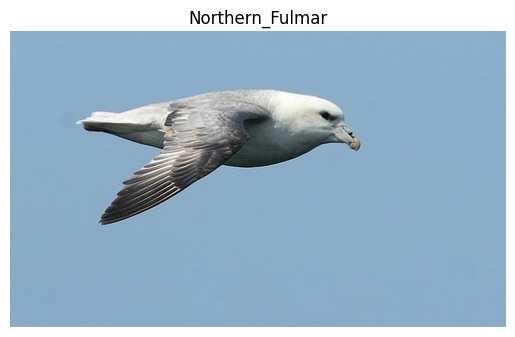

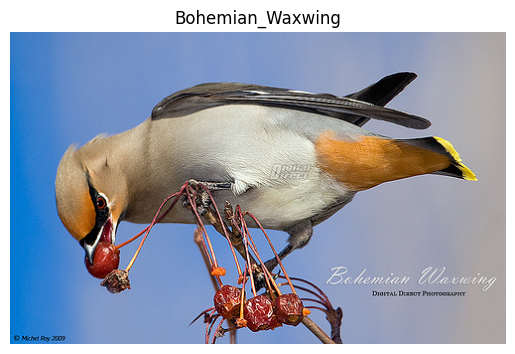

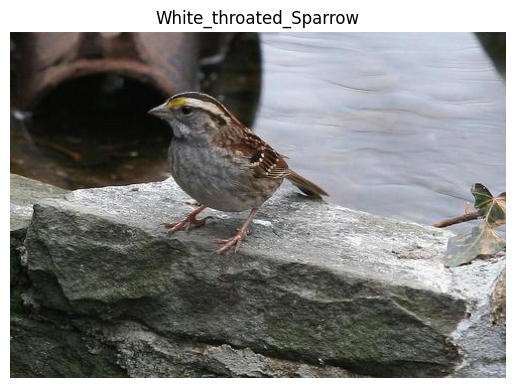

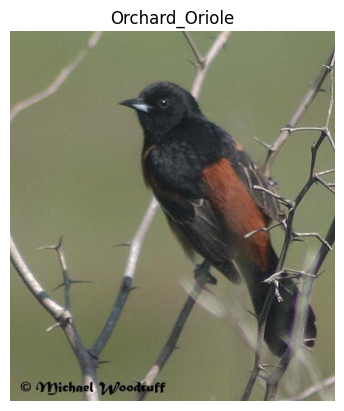

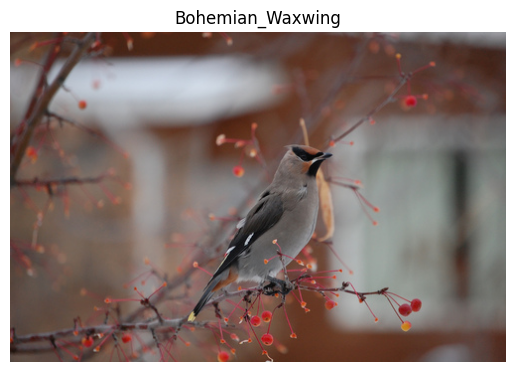

In [8]:
for row in sample.itertuples():
    img = Image.open(row.full_path)
    plt.imshow(img)
    plt.title(row.class_name.split('.')[-1])
    plt.axis("off")
    plt.show()

## Dataset Summary

In [9]:
df.head()

,image_id,file_path,class_id,class_name,is_train,full_path,set
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,Image_Raw/images/001.Black_footed_Albatross/Bl...,test
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,Image_Raw/images/001.Black_footed_Albatross/Bl...,test
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,Image_Raw/images/001.Black_footed_Albatross/Bl...,train


In [10]:
species_counts=df['class_name'].value_counts()
species_counts.head()

class_name
001.Black_footed_Albatross    60
002.Laysan_Albatross          60
004.Groove_billed_Ani         60
021.Eastern_Towhee            60
013.Bobolink                  60
Name: count, dtype: int64

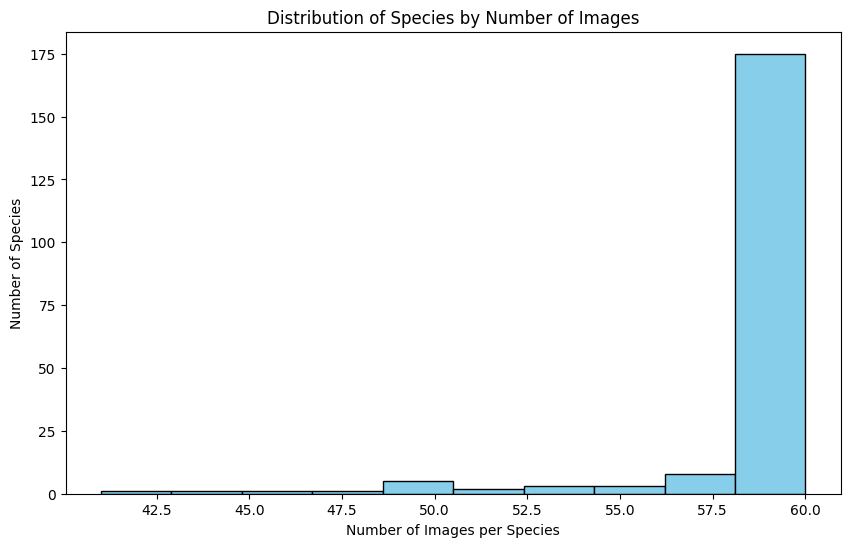

In [11]:
plt.figure(figsize=(10,6))
plt.hist(species_counts, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Number of Images per Species")
plt.ylabel("Number of Species")
plt.title("Distribution of Species by Number of Images")
plt.show()

In [12]:
split_counts = df['set'].value_counts()
split_counts

set
train    5994
test     5794
Name: count, dtype: int64

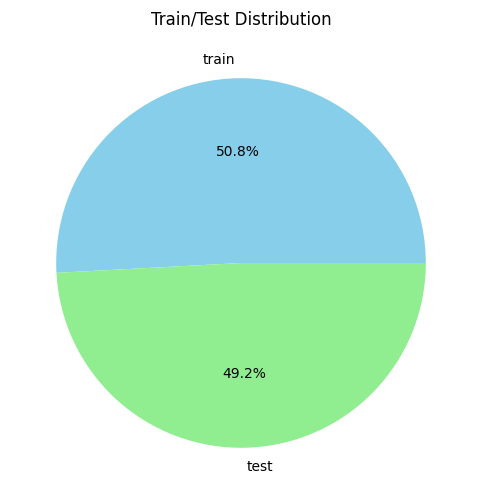

In [13]:
plt.figure(figsize=(6,6))
split_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue','lightgreen'])
plt.ylabel("")
plt.title("Train/Test Distribution")
plt.show()

## Interpret Results & Modeling Approach

Based on the dataset exploration:

- The dataset contains 200 bird species with varying number of images per species, mostly 60 images per species.  
- Images are split into training and testing sets.  
- Some classes may have fewer images, which could affect model performance.  

Since we have a large dataset (~11,788 images), a CNN-based approach is recommended for better accuracy.

## Pytorch Processing

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
class BirdsDataset(Dataset):
    def __init__(self, df, set_type="train", transform=None):
        self.df = df[df['set'] == set_type].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.full_path).convert("RGB") 
        label = row.class_id - 1  

        if self.transform:
            img = self.transform(img)

        return img, label


In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [17]:
RAW_DIR = "Image_Raw/images"

In [18]:
batch_size = 32
train_dataset = BirdsDataset(df, set_type="train", transform=train_transform)
test_dataset = BirdsDataset(df, set_type="test", transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

## Define CNN Model & Train

In [19]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 200)
model = model.to(device)

C:\Users\prani\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prani\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=3)

In [21]:
scaler = torch.amp.GradScaler(device="cuda")

In [22]:
num_epochs = 20
best_acc = 00 
best_model_path = "best_bird_model.pth"

### Training loop

In [23]:
for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    # ---- Test ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total

    # Step LR scheduler
    scheduler.step(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Train Acc: {train_acc:.4f} Test Acc: {test_acc:.4f}")

    # ---- Save Best Model ----
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with Test Acc: {best_acc:.4f}")

Epoch 1/20 [Train]:   0%|                                                                                                           | 0/188 [00:00<?, ?it/s]C:\Users\prani\AppData\Local\Temp\ipykernel_13452\3583837864.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [02:20<00:00,  1.34it/s]


Epoch [1/20] Loss: 4.2542 Train Acc: 0.1600 Test Acc: 0.3728
Best model saved with Test Acc: 0.3728


Epoch 2/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.11it/s]


Epoch [2/20] Loss: 2.3948 Train Acc: 0.4686 Test Acc: 0.5278
Best model saved with Test Acc: 0.5278


Epoch 3/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch [3/20] Loss: 1.5769 Train Acc: 0.6178 Test Acc: 0.6193
Best model saved with Test Acc: 0.6193


Epoch 4/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch [4/20] Loss: 1.1113 Train Acc: 0.7231 Test Acc: 0.6443
Best model saved with Test Acc: 0.6443


Epoch 5/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch [5/20] Loss: 0.8447 Train Acc: 0.7870 Test Acc: 0.6738
Best model saved with Test Acc: 0.6738


Epoch 6/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.09it/s]


Epoch [6/20] Loss: 0.6597 Train Acc: 0.8298 Test Acc: 0.6947
Best model saved with Test Acc: 0.6947


Epoch 7/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch [7/20] Loss: 0.5221 Train Acc: 0.8637 Test Acc: 0.6930


Epoch 8/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.09it/s]


Epoch [8/20] Loss: 0.4211 Train Acc: 0.8934 Test Acc: 0.6955
Best model saved with Test Acc: 0.6955


Epoch 9/20 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08it/s]


Epoch [9/20] Loss: 0.3579 Train Acc: 0.9054 Test Acc: 0.6892


Epoch 10/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.25it/s]


Epoch [10/20] Loss: 0.2893 Train Acc: 0.9313 Test Acc: 0.7099
Best model saved with Test Acc: 0.7099


Epoch 11/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch [11/20] Loss: 0.2434 Train Acc: 0.9403 Test Acc: 0.6957


Epoch 12/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.26it/s]


Epoch [12/20] Loss: 0.2145 Train Acc: 0.9484 Test Acc: 0.6888


Epoch 13/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch [13/20] Loss: 0.1961 Train Acc: 0.9521 Test Acc: 0.7071


Epoch 14/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch [14/20] Loss: 0.1458 Train Acc: 0.9695 Test Acc: 0.7025


Epoch 15/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.13it/s]


Epoch [15/20] Loss: 0.0863 Train Acc: 0.9838 Test Acc: 0.7553
Best model saved with Test Acc: 0.7553


Epoch 16/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.25it/s]


Epoch [16/20] Loss: 0.0485 Train Acc: 0.9942 Test Acc: 0.7639
Best model saved with Test Acc: 0.7639


Epoch 17/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch [17/20] Loss: 0.0416 Train Acc: 0.9945 Test Acc: 0.7648
Best model saved with Test Acc: 0.7648


Epoch 18/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:24<00:00,  2.23it/s]


Epoch [18/20] Loss: 0.0348 Train Acc: 0.9963 Test Acc: 0.7604


Epoch 19/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch [19/20] Loss: 0.0298 Train Acc: 0.9978 Test Acc: 0.7613


Epoch 20/20 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [01:24<00:00,  2.22it/s]


Epoch [20/20] Loss: 0.0278 Train Acc: 0.9973 Test Acc: 0.7622


In [24]:
print(f"Training complete. Best Validation Accuracy: {best_acc:.4f}")

Training complete. Best Validation Accuracy: 0.7648


## Save df for future use

In [25]:
df.to_csv("bird_metadata.csv", index=False)
